Find elevation data and average temperature data for US counties.
Compare elevation to annual temps and rainfall.
Import google maps and create topographical/weather/rainfall maps based on the county data.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from API_data import gmap_key
import requests
import gmaps
import time
import scipy.stats as st

pop_data_csvreader = pd.read_csv("./co-est2019-alldata.csv")
elevation_data = pd.read_csv("./POP_PLACES_20200501.txt",delimiter="|")
temp_csvreader = pd.read_csv("./Temperature_Data.csv")
precip_csvreader = pd.read_csv("./Precipitation_Data.csv")

In [2]:
# Format population data
pop_df = pd.DataFrame(pop_data_csvreader)
new_pop_df = pop_df[["CTYNAME","STABBREV","POPESTIMATE2010","POPESTIMATE2019"]]
new_pop_df = new_pop_df[new_pop_df["CTYNAME"].str.contains("County")]
new_pop_df = new_pop_df.reset_index(drop=True)
new_pop_df["County"] = new_pop_df["CTYNAME"] + ", " + new_pop_df["STABBREV"]
new_pop_df = new_pop_df.rename(columns={"POPESTIMATE2010":"2010 Pop","POPESTIMATE2019":"2019 Pop"})
new_pop_df["Pop Change"] = new_pop_df["2019 Pop"] - new_pop_df["2010 Pop"]
new_pop_df = new_pop_df[["County","2010 Pop","2019 Pop","Pop Change"]]
new_pop_df["Pop Growth Percent"] = round(100 * new_pop_df["Pop Change"]/new_pop_df["2010 Pop"],2)
new_pop_df.head()

,County,2010 Pop,2019 Pop,Pop Change,Pop Growth Percent
0,"Autauga County, AL",54773,55869,1096,2.00
1,"Baldwin County, AL",183112,223234,40122,21.91
2,"Barbour County, AL",27327,24686,-2641,-9.66
3,"Bibb County, AL",22870,22394,-476,-2.08
4,"Blount County, AL",57376,57826,450,0.78


In [3]:
# Format elevation data
elevation_data = pd.read_csv("./POP_PLACES_20200501.txt",delimiter="|")
elevation_data = elevation_data[["COUNTY_NAME","STATE_ALPHA","ELEV_IN_FT"]]
elevation_data = elevation_data.dropna(how='any')
elevation_data["COUNTY_NAME"] = elevation_data["COUNTY_NAME"].astype(str)+" County"
elevation_data["County"] = elevation_data["COUNTY_NAME"] + ", " + elevation_data["STATE_ALPHA"]
elevation_data = elevation_data[["County","ELEV_IN_FT"]]
new_elevation_data = elevation_data.rename(columns={"ELEV_IN_FT":"Elevation (feet)"})
county_elevations = new_elevation_data.groupby(["County"], as_index=False)
mean_county_elev = county_elevations.mean()
mean_county_elev.head()

,County,Elevation (feet)
0,"Abbeville County, SC",616.844828
1,"Acadia County, LA",31.040816
2,"Accomack County, VA",20.609756
3,"Ada County, ID",2842.896552
4,"Adair County, IA",1287.222222


In [4]:
# Format temperature data
temp_csvreader["2010-2019 Avg Temp (F)"] = (temp_csvreader["2010-2014 Avg Temp"] + temp_csvreader["2015-2019 Avg Temp"])/2
temp_df = temp_csvreader[["COUNTY","2010-2019 Avg Temp (F)"]]
temp_df = temp_df.rename(columns={"COUNTY":"County"})
temp_df.head()

,County,2010-2019 Avg Temp (F)
0,"Autauga County, AL",65.00
1,"Baldwin County, AL",67.85
2,"Barbour County, AL",65.65
3,"Bibb County, AL",63.60
4,"Blount County, AL",62.20


In [5]:
# Format precipitation data
precip_csvreader["2010-2019 Total (in)"] = precip_csvreader["2010-2014 Total (in)"]+precip_csvreader["2015-2019 Total (in)"]
precip_csvreader["2010-2019 Avg Annual Rainfall (in)"] = round(precip_csvreader["2010-2019 Total (in)"]/10,2)
precip_df = precip_csvreader[["Location","2010-2019 Avg Annual Rainfall (in)"]]
precip_df = precip_df.rename(columns={"Location":"County"})
precip_df.head()

,County,2010-2019 Avg Annual Rainfall (in)
0,"Autauga County, AL",54.36
1,"Baldwin County, AL",63.76
2,"Barbour County, AL",52.10
3,"Bibb County, AL",54.78
4,"Blount County, AL",57.20


In [6]:
# Merge temperature and precipitation dataframes together
weather_df = temp_df.merge(precip_df)
# weather_df

In [7]:
# Merge weather and elevation dataframes
geo_df = weather_df.merge(mean_county_elev)
# geo_df

In [8]:
# Merge geographic and population dataframes
complete_df = geo_df.merge(new_pop_df)
complete_df.head()

,County,2010-2019 Avg Temp (F),2010-2019 Avg Annual Rainfall (in),Elevation (feet),2010 Pop,2019 Pop,Pop Change,Pop Growth Percent
0,"Autauga County, AL",65.00,54.36,346.469697,54773,55869,1096,2.00
1,"Baldwin County, AL",67.85,63.76,103.361842,183112,223234,40122,21.91
2,"Barbour County, AL",65.65,52.10,410.263158,27327,24686,-2641,-9.66
3,"Bibb County, AL",63.60,54.78,424.610000,22870,22394,-476,-2.08
4,"Blount County, AL",62.20,57.20,726.052632,57376,57826,450,0.78


6.303024659697588e-23


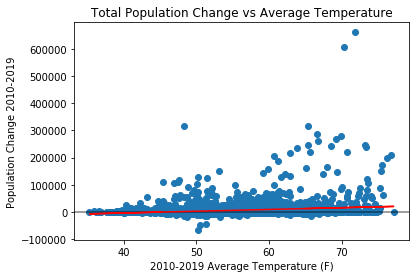

In [34]:
# Find correlation between weather and pop change
# Scatter plot of average temperature and total pop change
fig1,ax1 = plt.subplots()
ax1.scatter(complete_df["2010-2019 Avg Temp (F)"],complete_df["Pop Change"])
plt.xlabel("2010-2019 Average Temperature (F)")
plt.ylabel("Population Change 2010-2019")
plt.title("Total Population Change vs Average Temperature")
plt.axhline(y=0,color="black",alpha=0.5)
(slope,intercept,r_value,p_value,_) = st.linregress(complete_df["2010-2019 Avg Temp (F)"],complete_df["Pop Change"])
fit = slope * complete_df["2010-2019 Avg Temp (F)"] + intercept
ax1.plot(complete_df["2010-2019 Avg Temp (F)"],fit,"r")
print(p_value)
plt.savefig("./Project_Output_Pictures/TempScatter1.png")
plt.show()

4.235824628097604e-07


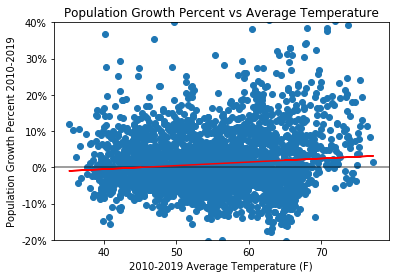

In [41]:
# Scatter plot of average temperature and pop growth percent
fig2,ax2 = plt.subplots()
labels=["-20%","-10%","0%","10%","20%","30%","40%"]
ax2.scatter(complete_df["2010-2019 Avg Temp (F)"],complete_df["Pop Growth Percent"])
plt.xlabel("2010-2019 Average Temperature (F)")
plt.ylabel("Population Growth Percent 2010-2019")
plt.title("Population Growth Percent vs Average Temperature")
plt.ylim(-20,40)
plt.yticks(np.arange(-20,50,step=10),labels)
plt.axhline(y=0,color="black",alpha=0.5)
(slope,intercept,r_value,p_value,_)=st.linregress(complete_df["2010-2019 Avg Temp (F)"],complete_df["Pop Growth Percent"])
fit = slope * complete_df["2010-2019 Avg Temp (F)"] + intercept
ax2.plot(complete_df["2010-2019 Avg Temp (F)"],fit,"r")
print(p_value)
plt.savefig("./Project_Output_Pictures/TempScatter2.png")
plt.show()

0.4055677817141482


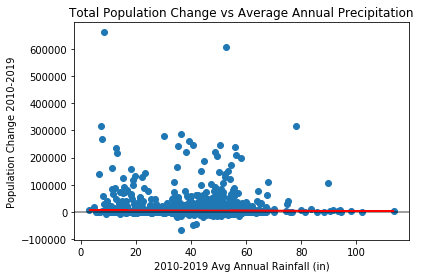

In [36]:
# Find correlation between precipitation and pop change
# Scatter plot of average annual precipitation and total pop change
fig3,ax3 = plt.subplots()
ax3.scatter(complete_df["2010-2019 Avg Annual Rainfall (in)"],complete_df["Pop Change"])
plt.xlabel("2010-2019 Avg Annual Rainfall (in)")
plt.ylabel("Population Change 2010-2019")
plt.title("Total Population Change vs Average Annual Precipitation")
plt.axhline(y=0,color="black",alpha=0.5)
(slope,intercept,r_value,p_value,_) = st.linregress(complete_df["2010-2019 Avg Annual Rainfall (in)"],complete_df["Pop Change"])
fit = slope * complete_df["2010-2019 Avg Annual Rainfall (in)"] + intercept
ax3.plot(complete_df["2010-2019 Avg Annual Rainfall (in)"],fit,"r")
print(p_value)
plt.savefig("./Project_Output_Pictures/PrecipScatter1.png")
plt.show()

0.21754813425872557


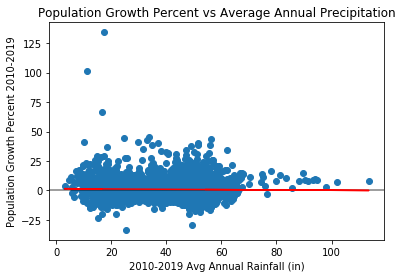

In [42]:
# Scatter plot of average annual precipitation and pop growth percent
fig4,ax4 = plt.subplots()
ax4.scatter(complete_df["2010-2019 Avg Annual Rainfall (in)"],complete_df["Pop Growth Percent"])
plt.xlabel("2010-2019 Avg Annual Rainfall (in)")
plt.ylabel("Population Growth Percent 2010-2019")
plt.title("Population Growth Percent vs Average Annual Precipitation")
plt.axhline(y=0,color="black",alpha=0.5)
(slope,intercept,r_value,p_value,_)=st.linregress(complete_df["2010-2019 Avg Annual Rainfall (in)"],complete_df["Pop Growth Percent"])
fit = slope * complete_df["2010-2019 Avg Annual Rainfall (in)"] + intercept
ax4.plot(complete_df["2010-2019 Avg Annual Rainfall (in)"],fit,"r")
print(p_value)
plt.savefig("./Project_Output_Pictures/PrecipScatter2.png")
plt.show()

0.007543704733587272


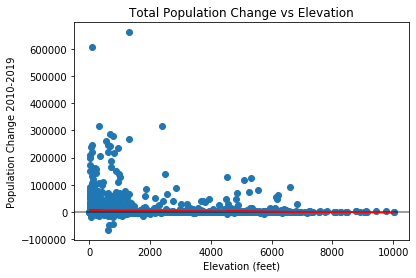

In [38]:
# Scatter plot of elevation and pop change
fig5,ax5 = plt.subplots()
ax5.scatter(complete_df["Elevation (feet)"],complete_df["Pop Change"])
plt.xlabel("Elevation (feet)")
plt.ylabel("Population Change 2010-2019")
plt.title("Total Population Change vs Elevation")
plt.axhline(y=0,color="black",alpha=0.5)
(slope,intercept,r_value,p_value,_) = st.linregress(complete_df["Elevation (feet)"],complete_df["Pop Change"])
fit = slope * complete_df["Elevation (feet)"] + intercept
ax5.plot(complete_df["Elevation (feet)"],fit,"r")
print(p_value)
plt.savefig("./Project_Output_Pictures/ElevScatter1.png")
plt.show()

0.0019382388743426615


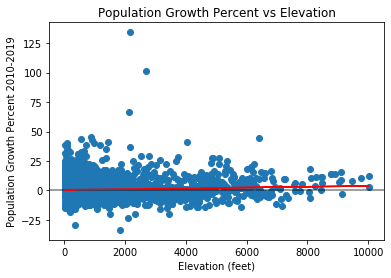

In [39]:
# Scatter plot of elevation and pop growth percent
fig6,ax6 = plt.subplots()
ax6.scatter(complete_df["Elevation (feet)"],complete_df["Pop Growth Percent"])
plt.xlabel("Elevation (feet)")
plt.ylabel("Population Growth Percent 2010-2019")
plt.title("Population Growth Percent vs Elevation")
plt.axhline(y=0,color="black",alpha=0.5)
(slope,intercept,r_value,p_value,_) = st.linregress(complete_df["Elevation (feet)"],complete_df["Pop Growth Percent"])
fit = slope * complete_df["Elevation (feet)"] + intercept
ax6.plot(complete_df["Elevation (feet)"],fit,"r")
print(p_value)
plt.savefig("./Project_Output_Pictures/ElevScatter2.png")
plt.show()

In [15]:
# group data to allow us to do API calls
grouped_df = complete_df
grouped_df["Group"] = ""
grouped_df["Index"] = grouped_df.index
group_list =[]    

for index, row in grouped_df.iterrows():
    if row["Index"] >= 0 and row["Index"] < 300:
        group_list.append("1")    
    if row["Index"] >= 300 and row["Index"] < 600:
        group_list.append("2")
    if row["Index"] >= 600 and row["Index"] < 900:
        group_list.append("3")
    if row["Index"] >= 900 and row["Index"] < 1200:
        group_list.append("4")
    if row["Index"] >= 1200 and row["Index"] < 1500:
        group_list.append("5")
    if row["Index"] >= 1500 and row["Index"] < 1800:
        group_list.append("6")
    if row["Index"] >= 1800 and row["Index"] < 2100:
        group_list.append("7")
    if row["Index"] >= 2100 and row["Index"] < 2400:
        group_list.append("8")
    if row["Index"] >= 2400 and row["Index"] < 2700:
        group_list.append("9")
    if row["Index"] >= 2700 and row["Index"] < 3002:
        group_list.append("10")
    
grouped_df["Group"] = group_list
grouped_df = grouped_df.drop(columns=["Index"])
grouped_df["Lat"] = ""
grouped_df["Lon"] = ""
grouped_df

,County,2010-2019 Avg Temp (F),2010-2019 Avg Annual Rainfall (in),Elevation (feet),2010 Pop,2019 Pop,Pop Change,Pop Growth Percent,Group,Lat,Lon
0,"Autauga County, AL",65.00,54.36,346.469697,54773,55869,1096,2.00,1,,
1,"Baldwin County, AL",67.85,63.76,103.361842,183112,223234,40122,21.91,1,,
2,"Barbour County, AL",65.65,52.10,410.263158,27327,24686,-2641,-9.66,1,,
3,"Bibb County, AL",63.60,54.78,424.610000,22870,22394,-476,-2.08,1,,
4,"Blount County, AL",62.20,57.20,726.052632,57376,57826,450,0.78,1,,
...,...,...,...,...,...,...,...,...,...,...,...
2996,"Sweetwater County, WY",42.75,10.11,6681.562500,43574,42343,-1231,-2.83,10,,
2997,"Teton County, WY",35.85,37.58,6585.350000,21296,23464,2168,10.18,10,,
2998,"Uinta County, WY",40.85,13.10,6817.791667,21089,20226,-863,-4.09,10,,
2999,"Washakie County, WY",44.90,13.36,4254.454545,8530,7805,-725,-8.50,10,,


In [17]:
# API call in sets of groups to get latitude/longitude coordinates for each county
base_url = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input="
lat_list = []
lon_list = []
for index, rows in grouped_df.iterrows():
    time.sleep(3)
    if rows["Group"] == "1":
        try:
            response = requests.get(f"{base_url}{rows['County']}&inputtype=textquery&fields=name,geometry&key={gmap_key}").json()
            try:
                lat = response["candidates"][0]["geometry"]["location"]["lat"]
                lon = response["candidates"][0]["geometry"]["location"]["lng"]
                lat_list.append(lat)
                lon_list.append(lon)
            except:
                try:
                    lat = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lat"]
                    lon = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lng"]
                    lat_list.append(lat)
                    lon_list.append(lon)             
                except:
                    try:
                        lat = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lat"]
                        lon = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lng"]
                        lat_list.append(lat)
                        lon_list.append(lon)                        
                    except:    
                        lat_list.append("NOT FOUND")
                        lon_list.append("NOT FOUND")
        except:
            pass
    else:
        pass
    if rows["Group"] == "2":
        try:
            response = requests.get(f"{base_url}{rows['County']}&inputtype=textquery&fields=name,geometry&key={gmap_key}").json()
            try:
                lat = response["candidates"][0]["geometry"]["location"]["lat"]
                lon = response["candidates"][0]["geometry"]["location"]["lng"]
                lat_list.append(lat)
                lon_list.append(lon)
            except:
                try:
                    lat = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lat"]
                    lon = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lng"]
                    lat_list.append(lat)
                    lon_list.append(lon)             
                except:
                    try:
                        lat = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lat"]
                        lon = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lng"]
                        lat_list.append(lat)
                        lon_list.append(lon)                        
                    except:    
                        lat_list.append("NOT FOUND")
                        lon_list.append("NOT FOUND")
        except:
            pass
    else:
        pass
    if rows["Group"] == "3":
        try:
            response = requests.get(f"{base_url}{rows['County']}&inputtype=textquery&fields=name,geometry&key={gmap_key}").json()
            try:
                lat = response["candidates"][0]["geometry"]["location"]["lat"]
                lon = response["candidates"][0]["geometry"]["location"]["lng"]
                lat_list.append(lat)
                lon_list.append(lon)
            except:
                try:
                    lat = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lat"]
                    lon = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lng"]
                    lat_list.append(lat)
                    lon_list.append(lon)             
                except:
                    try:
                        lat = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lat"]
                        lon = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lng"]
                        lat_list.append(lat)
                        lon_list.append(lon)                        
                    except:    
                        lat_list.append("NOT FOUND")
                        lon_list.append("NOT FOUND")
        except:
            pass
    else:
        pass
    if rows["Group"] == "4":
        try:
            response = requests.get(f"{base_url}{rows['County']}&inputtype=textquery&fields=name,geometry&key={gmap_key}").json()
            try:
                lat = response["candidates"][0]["geometry"]["location"]["lat"]
                lon = response["candidates"][0]["geometry"]["location"]["lng"]
                lat_list.append(lat)
                lon_list.append(lon)
            except:
                try:
                    lat = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lat"]
                    lon = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lng"]
                    lat_list.append(lat)
                    lon_list.append(lon)             
                except:
                    try:
                        lat = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lat"]
                        lon = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lng"]
                        lat_list.append(lat)
                        lon_list.append(lon)                        
                    except:    
                        lat_list.append("NOT FOUND")
                        lon_list.append("NOT FOUND")
        except:
            pass
    else:
        pass
    if rows["Group"] == "5":
        try:
            response = requests.get(f"{base_url}{rows['County']}&inputtype=textquery&fields=name,geometry&key={gmap_key}").json()
            try:
                lat = response["candidates"][0]["geometry"]["location"]["lat"]
                lon = response["candidates"][0]["geometry"]["location"]["lng"]
                lat_list.append(lat)
                lon_list.append(lon)
            except:
                try:
                    lat = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lat"]
                    lon = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lng"]
                    lat_list.append(lat)
                    lon_list.append(lon)             
                except:
                    try:
                        lat = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lat"]
                        lon = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lng"]
                        lat_list.append(lat)
                        lon_list.append(lon)                        
                    except:    
                        lat_list.append("NOT FOUND")
                        lon_list.append("NOT FOUND")
        except:
            pass
    else:
        pass
    if rows["Group"] == "6":
        try:
            response = requests.get(f"{base_url}{rows['County']}&inputtype=textquery&fields=name,geometry&key={gmap_key}").json()
            try:
                lat = response["candidates"][0]["geometry"]["location"]["lat"]
                lon = response["candidates"][0]["geometry"]["location"]["lng"]
                lat_list.append(lat)
                lon_list.append(lon)
            except:
                try:
                    lat = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lat"]
                    lon = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lng"]
                    lat_list.append(lat)
                    lon_list.append(lon)             
                except:
                    try:
                        lat = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lat"]
                        lon = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lng"]
                        lat_list.append(lat)
                        lon_list.append(lon)                        
                    except:    
                        lat_list.append("NOT FOUND")
                        lon_list.append("NOT FOUND")
        except:
            pass
    else:
        pass
    if rows["Group"] == "7":
        try:
            response = requests.get(f"{base_url}{rows['County']}&inputtype=textquery&fields=name,geometry&key={gmap_key}").json()
            try:
                lat = response["candidates"][0]["geometry"]["location"]["lat"]
                lon = response["candidates"][0]["geometry"]["location"]["lng"]
                lat_list.append(lat)
                lon_list.append(lon)
            except:
                try:
                    lat = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lat"]
                    lon = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lng"]
                    lat_list.append(lat)
                    lon_list.append(lon)             
                except:
                    try:
                        lat = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lat"]
                        lon = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lng"]
                        lat_list.append(lat)
                        lon_list.append(lon)                        
                    except:    
                        lat_list.append("NOT FOUND")
                        lon_list.append("NOT FOUND")
        except:
            pass
    else:
        pass
    if rows["Group"] == "8":
        try:
            response = requests.get(f"{base_url}{rows['County']}&inputtype=textquery&fields=name,geometry&key={gmap_key}").json()
            try:
                lat = response["candidates"][0]["geometry"]["location"]["lat"]
                lon = response["candidates"][0]["geometry"]["location"]["lng"]
                lat_list.append(lat)
                lon_list.append(lon)
            except:
                try:
                    lat = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lat"]
                    lon = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lng"]
                    lat_list.append(lat)
                    lon_list.append(lon)             
                except:
                    try:
                        lat = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lat"]
                        lon = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lng"]
                        lat_list.append(lat)
                        lon_list.append(lon)                        
                    except:    
                        lat_list.append("NOT FOUND")
                        lon_list.append("NOT FOUND")
        except:
            pass
    else:
        pass
    if rows["Group"] == "9":
        try:
            response = requests.get(f"{base_url}{rows['County']}&inputtype=textquery&fields=name,geometry&key={gmap_key}").json()
            try:
                lat = response["candidates"][0]["geometry"]["location"]["lat"]
                lon = response["candidates"][0]["geometry"]["location"]["lng"]
                lat_list.append(lat)
                lon_list.append(lon)
            except:
                try:
                    lat = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lat"]
                    lon = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lng"]
                    lat_list.append(lat)
                    lon_list.append(lon)             
                except:
                    try:
                        lat = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lat"]
                        lon = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lng"]
                        lat_list.append(lat)
                        lon_list.append(lon)                        
                    except:    
                        lat_list.append("NOT FOUND")
                        lon_list.append("NOT FOUND")
        except:
            pass
    else:
        pass
    if rows["Group"] == "10":
        try:
            response = requests.get(f"{base_url}{rows['County']}&inputtype=textquery&fields=name,geometry&key={gmap_key}").json()
            try:
                lat = response["candidates"][0]["geometry"]["location"]["lat"]
                lon = response["candidates"][0]["geometry"]["location"]["lng"]
                lat_list.append(lat)
                lon_list.append(lon)
            except:
                try:
                    lat = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lat"]
                    lon = response["candidates"][0]["geometry"]["viewport"]["northeast"]["lng"]
                    lat_list.append(lat)
                    lon_list.append(lon)             
                except:
                    try:
                        lat = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lat"]
                        lon = response["candidates"][0]["geometry"]["viewport"]["southwest"]["lng"]
                        lat_list.append(lat)
                        lon_list.append(lon)                        
                    except:    
                        lat_list.append("NOT FOUND")
                        lon_list.append("NOT FOUND")
        except:
            pass
    else:
        pass

In [20]:
print(len(lat_list))
print(len(lon_list))

3001
3001


In [47]:
grouped_df["Lat"] = lat_list
grouped_df["Lon"] = lon_list
grouped_df

,County,2010-2019 Avg Temp (F),2010-2019 Avg Annual Rainfall (in),Elevation (feet),2010 Pop,2019 Pop,Pop Change,Pop Growth Percent,Group,Lat,Lon
0,"Autauga County, AL",65.00,54.36,346.469697,54773,55869,1096,2.00,1,32.579182,-86.499655
1,"Baldwin County, AL",67.85,63.76,103.361842,183112,223234,40122,21.91,1,30.601074,-87.776333
2,"Barbour County, AL",65.65,52.10,410.263158,27327,24686,-2641,-9.66,1,31.817290,-85.354965
3,"Bibb County, AL",63.60,54.78,424.610000,22870,22394,-476,-2.08,1,32.956280,-87.142289
4,"Blount County, AL",62.20,57.20,726.052632,57376,57826,450,0.78,1,34.014515,-86.499655
...,...,...,...,...,...,...,...,...,...,...,...
2996,"Sweetwater County, WY",42.75,10.11,6681.562500,43574,42343,-1231,-2.83,10,41.851940,-109.188005
2997,"Teton County, WY",35.85,37.58,6585.350000,21296,23464,2168,10.18,10,43.853632,-110.631449
2998,"Uinta County, WY",40.85,13.10,6817.791667,21089,20226,-863,-4.09,10,41.210740,-110.616892
2999,"Washakie County, WY",44.90,13.36,4254.454545,8530,7805,-725,-8.50,10,43.834783,-107.703763


In [22]:
# google map weighted on pop growth percent
coordinates = grouped_df[["Lat", "Lon"]]
growth = grouped_df["Pop Growth Percent"]
growth = [0 if i < 0 else i for i in growth]
fig1 = gmaps.figure(center=(39,-97),zoom_level=3.9)
growth_heatmap = gmaps.heatmap_layer(locations=coordinates, weights=growth,max_intensity=15,dissipating=False,point_radius=.3)
fig1.add_layer(growth_heatmap)
fig1

Figure(layout=FigureLayout(height='420px'))

In [23]:
# google map weighted on temperatures
coordinates = grouped_df[["Lat", "Lon"]]
temp = grouped_df["2010-2019 Avg Temp (F)"]
fig2 = gmaps.figure(center=(39,-97),zoom_level=3.9)
temp_heatmap = gmaps.heatmap_layer(locations=coordinates, weights=temp,max_intensity=80,dissipating=False,point_radius=.3)
fig2.add_layer(temp_heatmap)
fig2

Figure(layout=FigureLayout(height='420px'))

In [24]:
# google map weighted on elevation
coordinates = grouped_df[["Lat", "Lon"]]
elevation = grouped_df["Elevation (feet)"]
fig4 = gmaps.figure(center=(39,-97),zoom_level=3.9)
elevation_heatmap = gmaps.heatmap_layer(locations=coordinates, weights=elevation,max_intensity=1500,dissipating=False,point_radius=.3)
fig4.add_layer(elevation_heatmap)
fig4

Figure(layout=FigureLayout(height='420px'))

In [25]:
# google map weighted on precipitation
coordinates = grouped_df[["Lat", "Lon"]]
precipitation = grouped_df["2010-2019 Avg Annual Rainfall (in)"]
fig3 = gmaps.figure(center=(39,-97),zoom_level=3.9)
precipitation_heatmap = gmaps.heatmap_layer(locations=coordinates, weights=precipitation,max_intensity=70,dissipating=False,point_radius=.3)
fig3.add_layer(precipitation_heatmap)
fig3

Figure(layout=FigureLayout(height='420px'))

Conclusion:
It does not appear that any of the 3 geographic variables in the study had a statistically significant effect on population change from 2010-2019. The scatter plots show that both total population changes and population change percentages had almost zero correlation with the county's average temperature, average annual precipitation, or elevation. The google maps also fail to show any statistically relevant correlation. For future studies, it would be better to try to limit population changes to only those due to human migration into or out of counties, and attempt to remove population changes due to births and deaths from the data. With this additional control, it will be easier to see how the geographic variables affect population changes due solely to population movement.

Data Sources:
https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html

https://worldpopulationreview.com/us-counties/

https://www.usgs.gov/core-science-systems/ngp/board-on-geographic-names/download-gnis-data

NOAA National Centers for Environmental information, Climate at a Glance: County Mapping, published June 2020, retrieved on June 30, 2020 from https://www.ncdc.noaa.gov/cag/